# State of the Art + ? Analytical Method

In [1]:
from utils.analytical.utils import *

Analytical approach of finding the external joint torque focuses on modeling and computing all the known torques acting at the joint such as friction, dynamics, position based torque (footprint).After compensatig for the known torques, the hypothesis is that the residual will be the external torque. Inorder to simplify the study, only Axis 3 was studied , the other joint angles were kept locked at 0°. 

## 3.1.1 Data Colleciton

To simplify the dynamics acting on the joint under study (Axis 3), the robot was mounted in a 90° orientation so that the axis of the joint is paralell to gravity, which allows the axis to be rotated wihtout gravity affetcing the dynamics. #insert figure for reference. 

In [2]:
#run this cell to download the data
from utils.download_utils import download_and_extract_zip

#data = download_and_extract_zip("analytical_dataset")
data = preprocess()

Processing 0.53:   0%|          | 0/3 [00:00<?, ?it/s]

preprocessing:   0%|          | 0/44 [00:00<?, ?it/s]

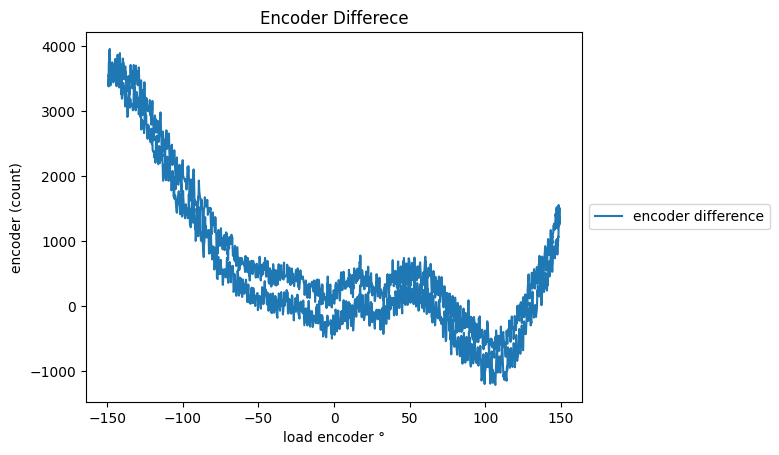

In [3]:
# Select a random sample from the dictionary
import random 

sample = random.choice(list(data.keys()))
plt.plot(data[sample].encoder_loadinc_3*count_to_deg,data[sample].encoder_motorinc_3/gear_ratio - data[sample].encoder_loadinc_3,label ='encoder difference')
plt.ylabel('encoder (count)')
plt.xlabel('load encoder °')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Encoder Differece")
plt.show()


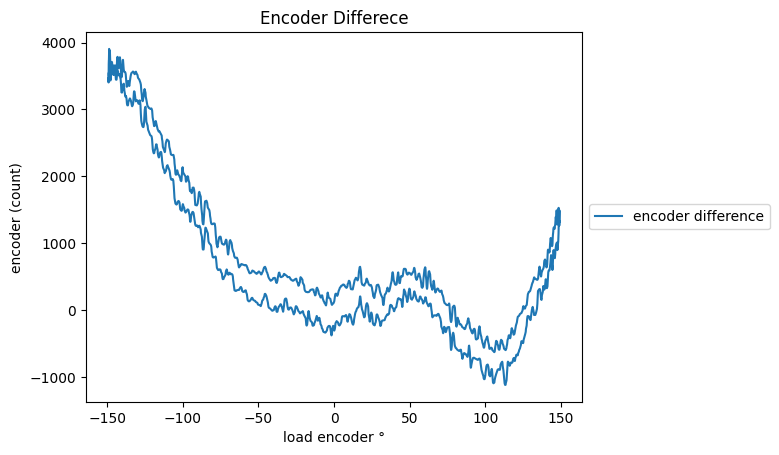

In [4]:
#apply low pass filter
for key in data:
    data[key]= filter(data[key],50)

plt.plot(data[sample].encoder_loadinc_3*count_to_deg,data[sample].filtered_motor_enc/gear_ratio - data[sample].filtered_load_enc,label ='encoder difference')
plt.ylabel('encoder (count)')
plt.xlabel('load encoder °')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Encoder Differece")
plt.show()

RMS value residual error: 0.007279126013914755
RMS value actual error: 0.03720630289263904
The Model has reduced the error


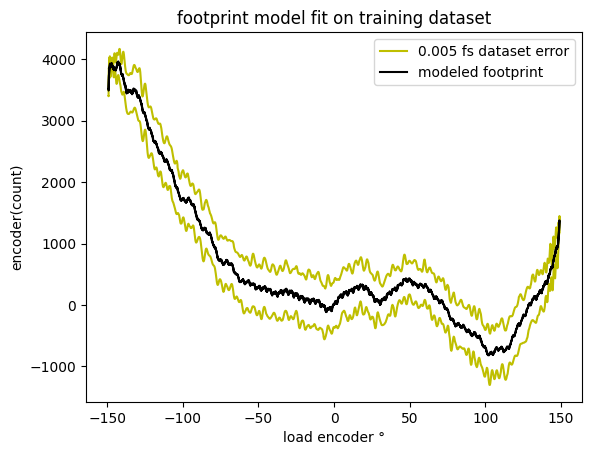

In [5]:
#learn foot print from the slowest data 
footprint_coeff = model_footprint(data["0.97"])
np.save("footprint_coeff.npy",footprint_coeff)

for key in data:
    data[key]['modeled_footprint'] = data[key].apply(lambda row: footprint_error(footprint_coeff,row["filtered_motor_enc"], row["filtered_load_enc"]), axis=1)


plt.plot(data["0.97"].encoder_loadinc_3*count_to_deg, (data["0.97"].filtered_motor_enc/gear_ratio - data["0.97"].filtered_load_enc) ,'y',label = '0.005 fs dataset error')
plt.plot(data["0.97"].encoder_loadinc_3*count_to_deg,data["0.97"].modeled_footprint/count_to_deg,'black',label = 'modeled footprint')
plt.ylabel('encoder(count)')
plt.xlabel('load encoder °')
plt.legend()
plt.title("footprint model fit on training dataset")
plt.show()
plt.close()



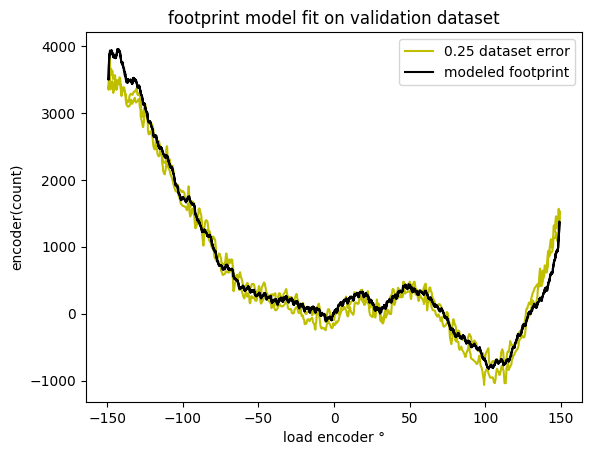

In [6]:
plt.plot(data["0.27"].encoder_loadinc_3*count_to_deg, (data["0.27"].filtered_motor_enc/gear_ratio - data["0.27"].filtered_load_enc) ,'y',label = '0.25 dataset error')
plt.plot(data["0.27"].encoder_loadinc_3*count_to_deg,data["0.27"].modeled_footprint/count_to_deg,'black',label = 'modeled footprint')
plt.ylabel('encoder(count)')
plt.xlabel('load encoder °')
plt.legend()
plt.title("footprint model fit on validation dataset")
plt.show()
plt.close()


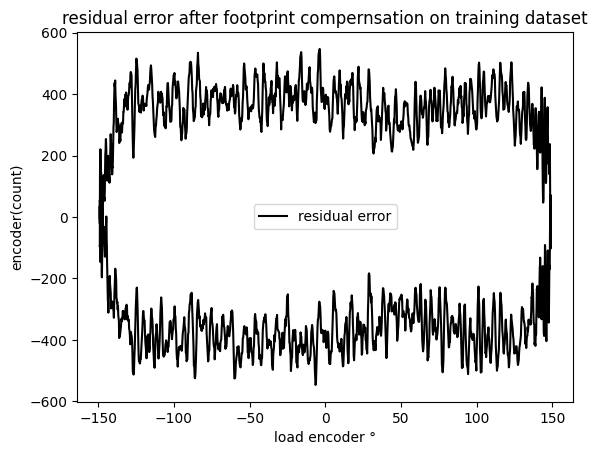

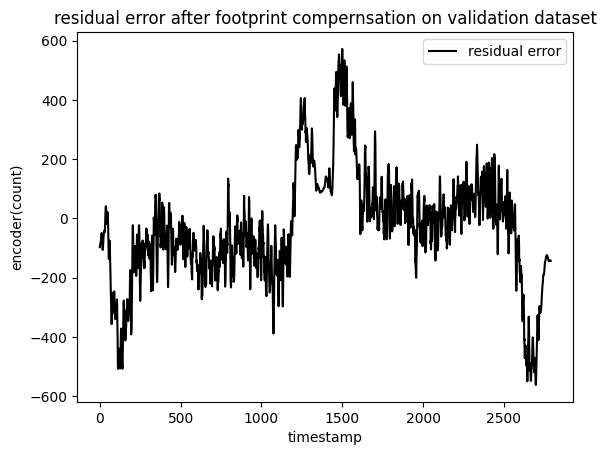

In [7]:
#calculate residuals by compensating for footprint
for key in data:
    data[key]['residual_error'] = data[key].filtered_motor_enc/gear_ratio - data[key].filtered_load_enc - data[key].modeled_footprint/count_to_deg #count

plt.plot(data["0.97"].encoder_loadinc_3*count_to_deg,data["0.97"].residual_error,'black',label = 'residual error')
plt.ylabel('encoder(count)')
plt.xlabel('load encoder °')
plt.legend()
plt.title("residual error after footprint compernsation on training dataset")
plt.show()
plt.close()

plt.plot(data["0.27"].residual_error,'black',label = 'residual error')
plt.ylabel('encoder(count)')
plt.xlabel('timestamp')
plt.legend()
plt.title("residual error after footprint compernsation on validation dataset")
plt.show()
plt.close()

In [8]:
#compensat for dynamics(remove friction component in dynamic)
for key in data:
    data[key]['inverse_dynamics'] = data[key].apply(lambda row:row["target_joint_torque_3"] - controller_friction_estimate(row["joint_velocity_3"]), axis=1)
    data[key]["dynamic_compensation"] = data[key].apply(lambda row: torque_to_encoder_error(row["inverse_dynamics"]), axis=1)
    data[key]["residual_error2"] = data[key].residual_error - data[key].dynamic_compensation

/usr/local/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


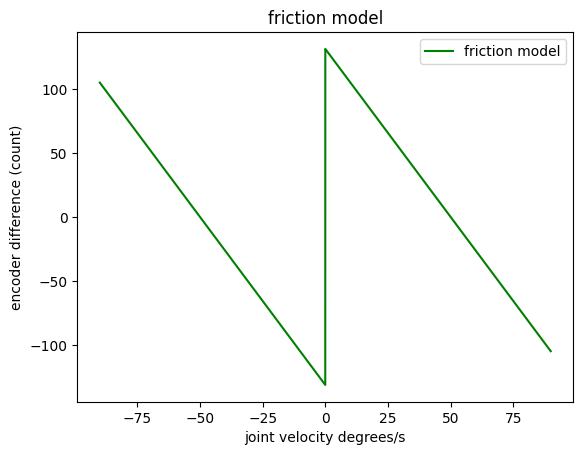

In [10]:
#append all dataframes
dfs = data["0.97"].iloc[:0,:].copy()
for key in data:
    dfs=pd.concat([dfs,data[key]])

#model friction
parameters,_ = curve_fit(friction_model,dfs.joint_velocity_3*radian_to_deg,dfs.residual_error2)
#save variables to file
np.save("friction_coeff.npy",parameters)

y = np.arange (-90, 90, 0.01)
x = friction_model(y,parameters[0],parameters[1],parameters[2],parameters[3],parameters[4],parameters[5])
plt.plot(y,x,'g',label='friction model')
plt.legend()
plt.xlabel("joint velocity degrees/s")
plt.ylabel("encoder difference (count)")
plt.title("friction model")
plt.legend()
plt.show()
plt.close()


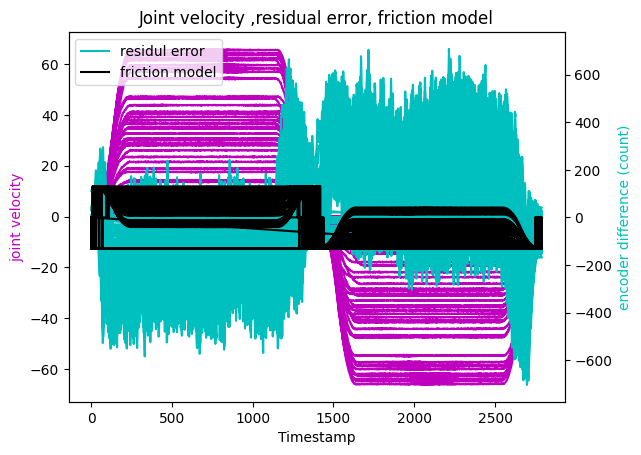

In [11]:


fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(dfs.joint_velocity_3*radian_to_deg,'m',label = " joint velocity")
ax2.plot( dfs.residual_error,'c',label = "residul error")
dfs['modeled_friction'] = dfs.apply(lambda row: friction_model(row["joint_velocity_3"]*radian_to_deg,parameters[0],parameters[1],parameters[2],parameters[3],parameters[4],parameters[5]), axis=1)
ax2.plot(dfs.modeled_friction,'black',label='friction model')
ax1.set_xlabel('Timestamp')
ax1.set_ylabel('joint velocity', color='m')
ax2.set_ylabel('encoder difference (count)', color='c')
ax2.legend()
plt.title("Joint velocity ,residual error, friction model")
plt.show()
plt.close()

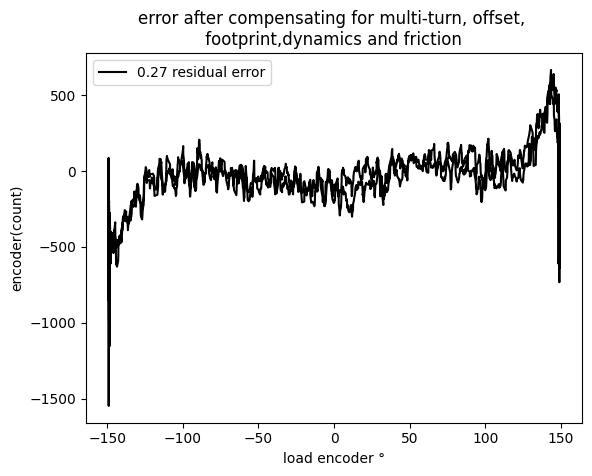

In [13]:
#comepnesate for friction
for key in data:
    data[key]['modeled_friction'] = data[key].apply(lambda row: friction_model(row["filtered_joint_velocity"]*radian_to_deg,parameters[0],parameters[1],parameters[2],parameters[3],parameters[4],parameters[5]), axis=1)
    data[key]["residual_error3"] = data[key].residual_error2 - data[key].modeled_friction
    

plt.plot(data["0.04"].encoder_loadinc_3*count_to_deg, data["0.04"].residual_error3,'black',label = '0.27 residual error')
plt.ylabel('encoder(count)')
plt.xlabel('load encoder °')
plt.legend()
plt.title("error after compensating for multi-turn, offset, \n footprint,dynamics and friction ")
plt.show()
plt.close()


